In [ ]:
! pip install transformers datasets

In [2]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git

Cloning into 'space-model'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 151 (delta 45), reused 125 (delta 22), pack-reused 0
Receiving objects: 100% (151/151), 29.68 MiB | 26.09 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [1]:
import sys

sys.path.append('space-model')

In [2]:
import pandas as pd

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

from datasets import Dataset, DatasetDict

from space_model.model import *
from space_model.loss import *

In [3]:
device_id = 0

In [4]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
torch.cuda.set_device(device)

In [10]:
# goss_fake_df = pd.read_csv('data/gossipcop_fake.csv', index_col=0)
# goss_fake_df['label'] = 1
# goss_fake_df['label'] = goss_fake_df['label'].astype(int)
#
# goss_real_df = pd.read_csv('data/gossipcop_real.csv', index_col=0)
# goss_real_df['label'] = 0
# goss_real_df['label'] = goss_real_df['label'].astype(int)

politi_fake_df = pd.read_csv('data/politifact_fake.csv', index_col=0)
politi_fake_df['label'] = 1
politi_fake_df['label'] = politi_fake_df['label'].astype(int)

politi_real_df = pd.read_csv('data/politifact_real.csv', index_col=0)
politi_real_df['label'] = 0
politi_real_df['label'] = politi_real_df['label'].astype(int)

train_df = pd.concat([
    # goss_fake_df,
    # goss_real_df,
    politi_fake_df,
    politi_real_df
], ignore_index=True, axis=0)

train_df = train_df[train_df['title'].notnull()]
train_df

,news_url,title,tweet_ids,label
0,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,1
1,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,1
2,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,1
3,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,1
4,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,1
...,...,...,...,...
1051,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,0
1052,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,0
1053,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,0
1054,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,0


<Axes: >

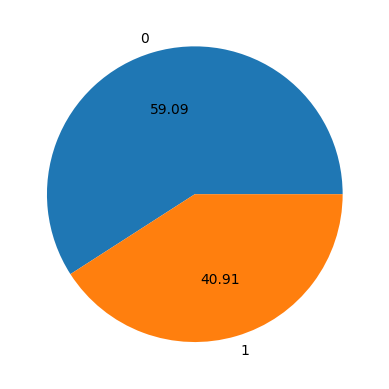

In [7]:
train_df.groupby('label').size().plot(kind='pie', autopct='%.2f')

In [37]:
MODEL_NAME = 'bert-base-cased'
MODELS_PATH = 'models'
DATASET_NAME = 'fake-news-net'

# SEED = 
NUM_EPOCHS = 50
BATCH_SIZE = 256
MAX_SEQ_LEN = 512
N_LATENT = 128

In [11]:
val_dataset = DatasetDict({
    'test': Dataset.from_pandas(train_df[['title', 'label']]),
})
val_dataset

DatasetDict({
    test: Dataset({
        features: ['title', 'label'],
        num_rows: 1056
    })
})

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [16]:
val_dataset = val_dataset.map(lambda x: tokenizer(x['title'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
val_dataset.set_format('torch', device=device)
val_dataset

Map:   0%|          | 0/1056 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['title', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1056
    })
})

## Base Model

In [14]:
state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}_{MODEL_NAME}_{NUM_EPOCHS}.bin')

In [15]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, state_dict=state_dict).to(device)
base_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

In [18]:
def concept_space_to_preds(concept_spaces):
    tensor_concept_spaces = torch.cat([cs.unsqueeze(0) for cs in concept_spaces], dim=0)
    concept_space_dist = tensor_concept_spaces.permute(1, 0, 2, 3).mean(dim=(2, 3)) # (B, n)
    return torch.argmax(concept_space_dist, dim=1).detach().cpu().tolist()

In [19]:
@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    cs_val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            ### Distance Based Classification
            # out.concept_spaces (n, B, seq_len, n_latent)
            if hasattr(outputs, 'concept_spaces'):
                cs_val_preds += concept_space_to_preds(outputs.concept_spaces)
            ### END

            val_loss += loss.item()
    return val_loss, val_preds, val_labels, cs_val_preds

In [20]:
val_dataloader = torch.utils.data.DataLoader(val_dataset['test'], batch_size=2 * BATCH_SIZE)

In [21]:
val_loss, val_preds, val_labels, _ = eval_epoch(base_model, val_dataloader)

100%|██████████| 3/3 [00:18<00:00,  6.30s/it]


In [24]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds, average='macro')
val_recall = recall_score(val_labels, val_preds, average='macro')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.5989654759565989
Val acc: 0.5909090909090909
Val f1: 0.37142857142857144
Val precision: 0.29545454545454547
Val recall: 0.5


## Space Model

In [38]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [39]:
space_model = SpaceModelForSequenceClassification(base_model, n_embed=768, n_latent=N_LATENT, n_concept_spaces=2, l1=0, l2=0).to(device)
space_model.load_state_dict(torch.load(f'{MODELS_PATH}/{DATASET_NAME}_space-{MODEL_NAME}-({N_LATENT})_{NUM_EPOCHS}.bin'))
space_model

SpaceModelForSequenceClassification(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [40]:
val_loss, val_preds, val_labels, cs_val_preds = eval_epoch(space_model, val_dataloader)

100%|██████████| 3/3 [00:18<00:00,  6.18s/it]


In [41]:
cs_val_acc = accuracy_score(val_labels, cs_val_preds)
cs_val_f1 = f1_score(val_labels, cs_val_preds, average='macro')

val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds, average='macro')
val_recall = recall_score(val_labels, val_preds, average='macro')

In [42]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'CS Val acc: {cs_val_acc}')
print(f'Val f1: {val_f1}')
print(f'CS Val f1: {cs_val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.531201163927714
Val acc: 0.6941287878787878
CS Val acc: 0.646780303030303
Val f1: 0.6395237868771897
CS Val f1: 0.6155446129219597
Val precision: 0.7171988037358195
Val recall: 0.6446759259259259
